# Introduction to using JUNE

This notebook aims to introduce users to the JUNE pipeline and demonstrate how:(1) a world and its demography can be constructed in JUNE, (2) the epidemiology in that world can be simulated, (3) how the results from a JUNE simulation can be processed. 

Prior to running this notebook be sure to clone the JUNE repository and run ```pip install -e .``` in the root of the repository.

### Import the relevant modules

In [1]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
from june import World 
from june.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import Infection, InfectionSelector, InfectionSelectors
from june.epidemiology.infection.health_index import Data2Rates
from june.epidemiology.infection.health_index.health_index import HealthIndexGenerator
from june.epidemiology.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries, Gyms
from june.groups.travel import *
from june.simulator import Simulator
from june.epidemiology.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.records import Record, RecordReader

from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/kqkc25/code/src/github/MarkLTurner/JUNE-private/Notebooks/data
No --configs argument given - defaulting to:
/home/kqkc25/code/src/github/MarkLTurner/JUNE-private/june/configs


# Creating a World

Prior to any JUNE simulation we need to construct a World. By the term 'World' we refer to a digital twin of the demography, geography and Supergroups that we want to simulate. 

Geography is captured in Regions, SuperAreas and Areas (a schema which allows JUNE simulations to operate with different topological data at different levels of granularity). Areas are the smallest geographical unit comprised of a latitude and longitude. A SuperArea is a spatially contiguous set of Areas and a SuperArea is a spatially contiguous set of Regions. Demography is responsible for the population attributes (e.g. sex, age ethnicity). Finally, SuperGroups are added, bringing, for example, households, companies and schools into our World.

To initialize a certain world, we need to add the different components we want to have in it. First we specify what SuperAreas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies. After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [3]:
%%time 

geography = Geography.from_file(
{
    "super_area": ["E02001731", "E02002566"]})

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_geography(geography)
world = generate_world_from_geography(geography, include_households=True)


2021-09-21 13:39:38,017 - june.geography.geography - INFO - There are 67 areas and 2 super_areas and 1 regions in the world.
2021-09-21 13:39:38,023 - hospitals - INFO - There are 1 hospitals in this geography.
2021-09-21 13:39:38,053 - schools - INFO - There are 7 schools in this geography.
2021-09-21 13:39:38,062 - schools - INFO - No school for the age 0 in this world.
2021-09-21 13:39:38,064 - schools - INFO - No school for the age 1 in this world.
2021-09-21 13:39:38,079 - schools - INFO - No school for the age 12 in this world.
2021-09-21 13:39:38,080 - schools - INFO - No school for the age 13 in this world.
2021-09-21 13:39:38,224 - care_homes - INFO - There are 4 care_homes in this geography.
2021-09-21 13:39:38,244 - universities - INFO - There are 3 universities in this world.
2021-09-21 13:39:43,160 - world - INFO - Populating areas
2021-09-21 13:39:43,681 - world - INFO - Areas populated. This world's population is: 19199
2021-09-21 13:39:45,413 - worker_distributor - INFO

## Configuring JUNE

We also specify the path to a config file that is important to how a JUNE simulation proceeds. Run the cell below to view the file.

We define the activities that our SuperGroups can carry out - for example, going to hospital, school etc. Further, we introduce time into our world. The `step_duration` deserves to be elaborated upon. It specifies the duration of each time step by day type - i.e. both for weekdays and weekends. According to the schema below weekdays are specified to have five time steps; a weekday starts with a one hour time step (when people commute), then 8 hours and so on. A weekend day will have three time stps of four hours and one of 12 hours. Users can modify this to add more timesteps or change the duration of a time step - the only requirement is that the duration of a day type sums to 24.

In [4]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"
os.environ["CONFIG_PATH"] = str(CONFIG_PATH)
!cat $CONFIG_PATH

title: Covid configuration example

activity_to_super_groups:
  medical_facility: ["hospitals"]
  primary_activity: ['schools', 'companies', "universities"]
  leisure: ['pubs', 'cinemas', 'groceries', 'gyms', "care_home_visits", "household_visits"] 
  residence: ['households', 'care_homes']
  commute: ['city_transports', 'inter_city_transports']

time:
  total_days: 30
  initial_day: "2020-03-01" 
  step_duration: 
      weekday:
          0: 1 
          1: 8
          2: 1
          3: 3
          4: 11
      weekend:
          0: 4 
          1: 4 
          2: 4 
          3: 12 
  step_activities:
      weekday:
          0: ['medical_facility', 'residence', 'commute'] 
          1: ['medical_facility', 'primary_activity', 'leisure', 'residence'] 
          2: ['medical_facility', 'residence', 'commute'] 
          3: ['medical_facility', 'leisure', 'residence']
          4: ['medical_facility', 'residence']
      weekend:
          0: ['medical_facility', 'leisure', 'residence']


## Commute, travel and leisure

Here we add further detail to our world. Specifically, we establish what our agents can do in their world.

In [5]:
%%time

world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
world.gyms = Gyms.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_areas(
    areas=world.areas, super_areas=world.super_areas
)


2021-09-21 13:39:49,987 - social_venue - INFO - Domain 0 has 2963 pubs(s)
2021-09-21 13:39:50,000 - social_venue - INFO - Domain 0 has 14 cinemas(s)
2021-09-21 13:39:50,236 - social_venue - INFO - Domain 0 has 834 groceries(s)
2021-09-21 13:39:50,294 - social_venue - INFO - Domain 0 has 174 gyms(s)
2021-09-21 13:39:50,346 - leisure - INFO - Linking households and care homes for visits
2021-09-21 13:39:50,390 - leisure - INFO - Done
2021-09-21 13:39:50,391 - leisure - INFO - Distributing social venues to areas
2021-09-21 13:39:50,391 - leisure - INFO - Distributed in 0 of 67 areas.
2021-09-21 13:39:50,449 - leisure - INFO - Distributed in 67 of 67 areas.
CPU times: user 1.28 s, sys: 11.7 ms, total: 1.29 s
Wall time: 1.29 s


Now we know where everyone works in our world, we can deduce the commutes that our agents would make - for example, when going into work. This is important to the way JUNE models the spread of a disease through a population.

In [6]:
travel = Travel()
travel.initialise_commute(world)

2021-09-21 13:39:50,456 - travel - INFO - Initialising commute...
2021-09-21 13:39:50,457 - travel - INFO - Creating cities...
2021-09-21 13:39:50,463 - travel - INFO - This world has 2 cities, with names
['Newcastle upon Tyne', 'Darlington']
2021-09-21 13:39:50,464 - travel - INFO - Determining people mode of transport
2021-09-21 13:39:56,386 - travel - INFO - Mode of transport allocated in 0 of 67 areas.
2021-09-21 13:39:56,407 - travel - INFO - Mode of transport determined for everyone.
2021-09-21 13:39:56,530 - travel - INFO - Assigning commuters to stations...
2021-09-21 13:39:56,531 - travel - INFO - Assigned 0 of 19199 potential commuters...
2021-09-21 13:39:56,535 - travel - INFO - Commuters assigned
2021-09-21 13:39:56,536 - travel - INFO - City Newcastle upon Tyne has 905 internal and 187 external commuters.
2021-09-21 13:39:56,538 - travel - INFO - Creating stations...
2021-09-21 13:39:56,540 - travel - INFO - City Newcastle upon Tyne has 1 city and 4 inter city stations.
20

Finally, we are also going to need some cemeteries...


In [7]:
world.cemeteries = Cemeteries()

## How to 'save the world'

If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later. Here we write the state of our World object to a file called `world.hdf5`

In [8]:
world.to_hdf5("world.hdf5")

2021-09-21 13:39:56,553 - world_saver - INFO - saving world to HDF5
2021-09-21 13:39:56,566 - world_saver - INFO - saving population...
2021-09-21 13:39:56,956 - world_saver - INFO - saving hospitals...
2021-09-21 13:39:56,959 - world_saver - INFO - saving schools...
2021-09-21 13:39:56,963 - world_saver - INFO - saving companies...
2021-09-21 13:39:56,968 - world_saver - INFO - saving households...
2021-09-21 13:39:57,124 - world_saver - INFO - saving care homes...
2021-09-21 13:39:57,127 - world_saver - INFO - saving cities...
2021-09-21 13:39:57,130 - world_saver - INFO - saving stations...
2021-09-21 13:39:57,133 - world_saver - INFO - saving universities...
2021-09-21 13:39:57,135 - world_saver - INFO - saving social venues...
2021-09-21 13:39:57,148 - world_saver - INFO - Saving domain decomposition data...


If we would like to load the world we saved, we just do:

In [9]:
world = generate_world_from_hdf5("world.hdf5")

2021-09-21 13:39:57,154 - world_saver - INFO - loading world from HDF5
2021-09-21 13:39:57,161 - world_saver - INFO - loading hospitals...
2021-09-21 13:39:57,164 - world_saver - INFO - loading schools...
2021-09-21 13:39:57,169 - company_saver - INFO - loading companies...
2021-09-21 13:39:57,170 - company_saver - INFO - Companies chunk 0 of 1
2021-09-21 13:39:57,182 - world_saver - INFO - loading care homes...
2021-09-21 13:39:57,184 - world_saver - INFO - loading universities...
2021-09-21 13:39:57,187 - world_saver - INFO - loading cities...
2021-09-21 13:39:57,190 - world_saver - INFO - loading stations...
2021-09-21 13:39:57,193 - household_saver - INFO - loading households...
2021-09-21 13:39:57,193 - household_saver - INFO - Loaded chunk 0 of 1
2021-09-21 13:39:57,269 - population saver - INFO - loading population...
2021-09-21 13:39:57,270 - population saver - INFO - Loaded chunk 0 of 1
2021-09-21 13:39:57,375 - world_saver - INFO - loading social venues...
2021-09-21 13:39:57

Note: if we load the world from a file we have to regenerate the leisure object that draws on information in the world:

In [10]:
leisure = generate_leisure_for_config(world, CONFIG_PATH)

Similarly, a travel object must also be redefined:

In [11]:
travel = Travel()

You have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [12]:
selector = InfectionSelector.from_file()
selectors = InfectionSelectors([selector])

All the functionality related to infections is handled by the Epidemiology class.

In [13]:
epidemiology = Epidemiology(infection_selectors=selectors)

# Adding the interaction

June models human-to-human transmissible diseases. The model, therefore, needs information about the interactions between its agents. We read this out of a config file: `june/configs/defaults/interaction/interaction.yaml`

In [14]:
interaction = Interaction.from_file()

Betas are the intensities of the interaction taking place at the different groups

In [15]:
interaction.betas

{'box': 1,
 'pub': 0.42941,
 'gym': 0.42941,
 'grocery': 0.04137,
 'cinema': 0.157461,
 'city_transport': 0.107969,
 'inter_city_transport': 0.383,
 'hospital': 0.1168,
 'care_home': 0.28,
 'company': 0.371,
 'school': 0.07,
 'household': 0.208,
 'household_visits': 0.208,
 'care_visits': 0.208,
 'university': 0.306}

Moreover, this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [16]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [17]:
infection_seed = InfectionSeed(
    world, selector,
)

In [18]:
n_cases = 50
infection_seed.unleash_virus(
    population=world.people,
    n_cases=n_cases, # play around with the initial number of cases
    time=0
)

# Set policies

JUNE's policy layer allows users to experiment with policy measures designed to control and redice the impact of human to human transmissible diseases. These might include social distancing measures, the closure of schools or restaurants and much more. Since JUNE has highly granular layers of geographical knowledge, policies can be tested on regional levels or even in relation to specific individuals and venues.

Here we load in the set of policies captured in `june/configs/defaults/policy/policy.yaml`

In [19]:
policies = Policies.from_file()

We can have a look at one of the policies

In [20]:
print(policies.individual_policies[8].__dict__)

{'spec': 'close_companies', 'start_time': datetime.datetime(2020, 3, 16, 0, 0), 'end_time': datetime.datetime(2020, 3, 20, 0, 0), 'policy_type': 'individual', 'policy_subtype': 'skip_activity', 'activities_to_remove': ['primary_activity', 'commute'], 'full_closure': False, 'avoid_work_probability': 0.2, 'furlough_probability': 0.04, 'key_probability': 0.22}


# Run the simulation

The first thing we need is a place to save our simulation results. For that we can use the record class, and pass it to the simulator.

In [21]:
record = Record(    
    record_path = 'results',    
    record_static_data=True,
) 

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at https://github.com/IDAS-Durham/JUNE/blob/master/june/configs/config_example.yaml

In [22]:
simulator = Simulator.from_file(
    world=world,
    epidemiology=epidemiology,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    travel = travel,
    record=record,
    policies = policies
)

In [23]:
%%time
simulator.run()

2021-09-21 13:39:58,456 - simulator - INFO - Starting simulation for 30 days at day 2020-03-01 00:00:00,to run for 30 days
2021-09-21 13:39:58,639 - rank - INFO - Next timestep
2021-09-21 13:39:58,640 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:39:59,003 - rank - INFO - Rank 0 -- move_people -- 0.3625070760026574
2021-09-21 13:39:59,003 - rank - INFO - Rank 0 -- move_people_waiting -- 6.546004442498088e-06
2021-09-21 13:39:59,004 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.85300484392792e-06,2.6226043701171875e-06 - 2020-03-01 00:00:00
2021-09-21 13:39:59,006 - simulator - INFO - Info for rank 0, Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 50
2021-09-21 13:39:59,079 - rank - INFO - Rank 0 -- interaction -- 0.07475187499949243
2021-09-21 13:39:59,080 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002606190100777894,0.0002605915069580078 - 2020-03-01 00:00:00
2021-09-21 13:39:59,172 

2021-09-21 13:40:01,104 - simulator - INFO - Info for rank 0, Date = 2020-03-02 10:00:00, number of deaths =  0, number of infected = 54
2021-09-21 13:40:01,177 - rank - INFO - Rank 0 -- interaction -- 0.07471966500452254
2021-09-21 13:40:01,178 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020188199414405972,0.000202178955078125 - 2020-03-02 10:00:00
2021-09-21 13:40:01,199 - rank - INFO - Rank 0 -- interaction_waiting -- 4.6240020310506225e-06
2021-09-21 13:40:01,213 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013985702011268586,0.013985872268676758 - 2020-03-02 10:00:00

2021-09-21 13:40:01,214 - rank - INFO - Next timestep
2021-09-21 13:40:01,214 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:01,267 - rank - INFO - Rank 0 -- move_people -- 0.052453381998930126
2021-09-21 13:40:01,267 - rank - INFO - Rank 0 -- move_people_waiting -- 7.661990821361542e-06
2021-09-21 13:40:01,268 - activity_manager - INFO - CMS: Peo

2021-09-21 13:40:02,714 - rank - INFO - Next timestep
2021-09-21 13:40:02,715 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:02,789 - rank - INFO - Rank 0 -- move_people -- 0.0738580710021779
2021-09-21 13:40:02,790 - rank - INFO - Rank 0 -- move_people_waiting -- 6.115995347499847e-06
2021-09-21 13:40:02,790 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.510009264573455e-06,3.0994415283203125e-06 - 2020-03-04 01:00:00
2021-09-21 13:40:02,793 - simulator - INFO - Info for rank 0, Date = 2020-03-04 01:00:00, number of deaths =  0, number of infected = 65
2021-09-21 13:40:02,936 - rank - INFO - Rank 0 -- interaction -- 0.14495664299465716
2021-09-21 13:40:02,942 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002187429927289486,0.0002181529998779297 - 2020-03-04 01:00:00
2021-09-21 13:40:02,964 - rank - INFO - Rank 0 -- interaction_waiting -- 5.1910028560087085e-06
2021-09-21 13:40:02,978 - simulator - INFO - CMS: 

2021-09-21 13:40:04,624 - rank - INFO - Rank 0 -- interaction -- 0.08449648499663454
2021-09-21 13:40:04,626 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021263700909912586,0.00021266937255859375 - 2020-03-05 10:00:00
2021-09-21 13:40:04,649 - rank - INFO - Rank 0 -- interaction_waiting -- 5.533001967705786e-06
2021-09-21 13:40:04,664 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014985617002821527,0.014986038208007812 - 2020-03-05 10:00:00

2021-09-21 13:40:04,664 - rank - INFO - Next timestep
2021-09-21 13:40:04,665 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:04,717 - rank - INFO - Rank 0 -- move_people -- 0.05235219000314828
2021-09-21 13:40:04,718 - rank - INFO - Rank 0 -- move_people_waiting -- 7.179012754932046e-06
2021-09-21 13:40:04,718 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.559995093382895e-06,3.337860107421875e-06 - 2020-03-05 13:00:00
2021-09-21 13:40:04,722 - simulator - INFO - In

2021-09-21 13:40:06,442 - rank - INFO - Rank 0 -- move_people -- 0.17491110999253578
2021-09-21 13:40:06,443 - rank - INFO - Rank 0 -- move_people_waiting -- 7.78399407863617e-06
2021-09-21 13:40:06,443 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6910059861838818e-06,3.337860107421875e-06 - 2020-03-07 04:00:00
2021-09-21 13:40:06,447 - simulator - INFO - Info for rank 0, Date = 2020-03-07 04:00:00, number of deaths =  0, number of infected = 123
2021-09-21 13:40:06,528 - rank - INFO - Rank 0 -- interaction -- 0.08380597400537226
2021-09-21 13:40:06,530 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00028363200544845313,0.0002837181091308594 - 2020-03-07 04:00:00
2021-09-21 13:40:06,553 - rank - INFO - Rank 0 -- interaction_waiting -- 5.399997462518513e-06
2021-09-21 13:40:06,568 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015046817003167234,0.015047073364257812 - 2020-03-07 04:00:00

2021-09-21 13:40:06,569 - rank - INFO - Next timestep
2021-0

2021-09-21 13:40:08,247 - rank - INFO - Rank 0 -- interaction_waiting -- 8.467002771794796e-06
2021-09-21 13:40:08,261 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013657344010425732,0.013657569885253906 - 2020-03-09 00:00:00

2021-09-21 13:40:08,261 - rank - INFO - Next timestep
2021-09-21 13:40:08,262 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:08,332 - rank - INFO - Rank 0 -- move_people -- 0.06995930000266526
2021-09-21 13:40:08,333 - rank - INFO - Rank 0 -- move_people_waiting -- 8.171002264134586e-06
2021-09-21 13:40:08,333 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.369990736246109e-06,2.86102294921875e-06 - 2020-03-09 01:00:00
2021-09-21 13:40:08,337 - simulator - INFO - Info for rank 0, Date = 2020-03-09 01:00:00, number of deaths =  0, number of infected = 150
2021-09-21 13:40:08,574 - rank - INFO - Rank 0 -- interaction -- 0.23999190000176895
2021-09-21 13:40:08,579 - epidemiology - INFO - CMS: Infection C

2021-09-21 13:40:10,288 - simulator - INFO - Info for rank 0, Date = 2020-03-10 10:00:00, number of deaths =  0, number of infected = 189
2021-09-21 13:40:10,369 - rank - INFO - Rank 0 -- interaction -- 0.08232957898871973
2021-09-21 13:40:10,370 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024369399761781096,0.00024390220642089844 - 2020-03-10 10:00:00
2021-09-21 13:40:10,392 - rank - INFO - Rank 0 -- interaction_waiting -- 4.59399598184973e-06
2021-09-21 13:40:10,407 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014981714004534297,0.014981985092163086 - 2020-03-10 10:00:00

2021-09-21 13:40:10,407 - rank - INFO - Next timestep
2021-09-21 13:40:10,408 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:10,458 - rank - INFO - Rank 0 -- move_people -- 0.0499028259946499
2021-09-21 13:40:10,458 - rank - INFO - Rank 0 -- move_people_waiting -- 5.845999112352729e-06
2021-09-21 13:40:10,459 - activity_manager - INFO - CMS: Peop

2021-09-21 13:40:11,921 - rank - INFO - Next timestep
2021-09-21 13:40:11,922 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:11,992 - rank - INFO - Rank 0 -- move_people -- 0.06992955700843595
2021-09-21 13:40:11,993 - rank - INFO - Rank 0 -- move_people_waiting -- 8.051007171161473e-06
2021-09-21 13:40:11,993 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6389974411576986e-06,3.337860107421875e-06 - 2020-03-12 01:00:00
2021-09-21 13:40:11,996 - simulator - INFO - Info for rank 0, Date = 2020-03-12 01:00:00, number of deaths =  0, number of infected = 214
2021-09-21 13:40:12,152 - rank - INFO - Rank 0 -- interaction -- 0.15825742500601336
2021-09-21 13:40:12,157 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00039812100294511765,0.0003979206085205078 - 2020-03-12 01:00:00
2021-09-21 13:40:12,175 - rank - INFO - Rank 0 -- interaction_waiting -- 4.842993803322315e-06
2021-09-21 13:40:12,189 - simulator - INFO - CMS

2021-09-21 13:40:13,852 - rank - INFO - Rank 0 -- interaction -- 0.09387258099741302
2021-09-21 13:40:13,855 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004741809971164912,0.0004742145538330078 - 2020-03-13 10:00:00
2021-09-21 13:40:13,885 - rank - INFO - Rank 0 -- interaction_waiting -- 6.900998414494097e-06
2021-09-21 13:40:13,899 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01429584200377576,0.01429605484008789 - 2020-03-13 10:00:00

2021-09-21 13:40:13,900 - rank - INFO - Next timestep
2021-09-21 13:40:13,900 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:13,952 - rank - INFO - Rank 0 -- move_people -- 0.050926255993545055
2021-09-21 13:40:13,952 - rank - INFO - Rank 0 -- move_people_waiting -- 7.223003194667399e-06
2021-09-21 13:40:13,953 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8799986466765404e-06,2.86102294921875e-06 - 2020-03-13 13:00:00
2021-09-21 13:40:13,955 - simulator - INFO - Info 

2021-09-21 13:40:15,905 - rank - INFO - Rank 0 -- move_people -- 0.16916655999375507
2021-09-21 13:40:15,905 - rank - INFO - Rank 0 -- move_people_waiting -- 6.73800241202116e-06
2021-09-21 13:40:15,906 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1840027077123523e-06,2.86102294921875e-06 - 2020-03-15 08:00:00
2021-09-21 13:40:15,908 - simulator - INFO - Info for rank 0, Date = 2020-03-15 08:00:00, number of deaths =  0, number of infected = 284
2021-09-21 13:40:15,992 - rank - INFO - Rank 0 -- interaction -- 0.085451227001613
2021-09-21 13:40:15,994 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002492890052963048,0.00024890899658203125 - 2020-03-15 08:00:00
2021-09-21 13:40:16,017 - rank - INFO - Rank 0 -- interaction_waiting -- 5.9589947341009974e-06
2021-09-21 13:40:16,032 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015142060990910977,0.015142440795898438 - 2020-03-15 08:00:00

2021-09-21 13:40:16,033 - rank - INFO - Next timestep
2021-09-

2021-09-21 13:40:18,343 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002995750110130757,0.00029969215393066406 - 2020-03-17 00:00:00
2021-09-21 13:40:18,367 - rank - INFO - Rank 0 -- interaction_waiting -- 4.761997843161225e-06
2021-09-21 13:40:18,381 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01439360500080511,0.014393329620361328 - 2020-03-17 00:00:00

2021-09-21 13:40:18,382 - rank - INFO - Next timestep
2021-09-21 13:40:18,382 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:18,569 - rank - INFO - Rank 0 -- move_people -- 0.1857938600005582
2021-09-21 13:40:18,569 - rank - INFO - Rank 0 -- move_people_waiting -- 5.919995601288974e-06
2021-09-21 13:40:18,570 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.106004442088306e-06,2.86102294921875e-06 - 2020-03-17 01:00:00
2021-09-21 13:40:18,572 - simulator - INFO - Info for rank 0, Date = 2020-03-17 01:00:00, number of deaths =  0, number of infected = 32

2021-09-21 13:40:21,026 - rank - INFO - Rank 0 -- move_people_waiting -- 6.375004886649549e-06
2021-09-21 13:40:21,026 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6320049073547125e-06,2.1457672119140625e-06 - 2020-03-18 10:00:00
2021-09-21 13:40:21,028 - simulator - INFO - Info for rank 0, Date = 2020-03-18 10:00:00, number of deaths =  0, number of infected = 368
2021-09-21 13:40:21,114 - rank - INFO - Rank 0 -- interaction -- 0.08796163900115062
2021-09-21 13:40:21,116 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021019199630245566,0.00021004676818847656 - 2020-03-18 10:00:00
2021-09-21 13:40:21,139 - rank - INFO - Rank 0 -- interaction_waiting -- 5.808004061691463e-06
2021-09-21 13:40:21,153 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013738080000621267,0.01373744010925293 - 2020-03-18 10:00:00

2021-09-21 13:40:21,153 - rank - INFO - Next timestep
2021-09-21 13:40:21,153 - simulator - INFO - ==================== timestep ==============

2021-09-21 13:40:23,375 - rank - INFO - Rank 0 -- interaction_waiting -- 4.771995008923113e-06
2021-09-21 13:40:23,388 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013045824991422705,0.013046503067016602 - 2020-03-20 00:00:00

2021-09-21 13:40:23,389 - rank - INFO - Next timestep
2021-09-21 13:40:23,390 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:23,671 - rank - INFO - Rank 0 -- move_people -- 0.28139965899754316
2021-09-21 13:40:23,672 - rank - INFO - Rank 0 -- move_people_waiting -- 5.950001650489867e-06
2021-09-21 13:40:23,672 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1939998734742403e-06,2.86102294921875e-06 - 2020-03-20 01:00:00
2021-09-21 13:40:23,675 - simulator - INFO - Info for rank 0, Date = 2020-03-20 01:00:00, number of deaths =  0, number of infected = 413
2021-09-21 13:40:23,788 - rank - INFO - Rank 0 -- interaction -- 0.11512284999480471
2021-09-21 13:40:23,793 - epidemiology - INFO - CMS: Infection 

2021-09-21 13:40:26,409 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.092995029874146e-06,3.0994415283203125e-06 - 2020-03-21 12:00:00
2021-09-21 13:40:26,411 - simulator - INFO - Info for rank 0, Date = 2020-03-21 12:00:00, number of deaths =  0, number of infected = 437
2021-09-21 13:40:26,484 - rank - INFO - Rank 0 -- interaction -- 0.07516454299911857
2021-09-21 13:40:26,490 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00029602801077999175,0.00029540061950683594 - 2020-03-21 12:00:00
2021-09-21 13:40:26,514 - rank - INFO - Rank 0 -- interaction_waiting -- 4.565998096950352e-06
2021-09-21 13:40:26,527 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013565586996264756,0.013566255569458008 - 2020-03-21 12:00:00

2021-09-21 13:40:26,528 - rank - INFO - Next timestep
2021-09-21 13:40:26,528 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:26,824 - rank - INFO - Rank 0 -- move_people -- 0.2957367670023814
2021

2021-09-21 13:40:29,094 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013724373988225125,0.013724565505981445 - 2020-03-23 09:00:00

2021-09-21 13:40:29,095 - rank - INFO - Next timestep
2021-09-21 13:40:29,095 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:29,446 - rank - INFO - Rank 0 -- move_people -- 0.3506846800009953
2021-09-21 13:40:29,447 - rank - INFO - Rank 0 -- move_people_waiting -- 4.603993147611618e-06
2021-09-21 13:40:29,448 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.463996108621359e-06,3.337860107421875e-06 - 2020-03-23 10:00:00
2021-09-21 13:40:29,450 - simulator - INFO - Info for rank 0, Date = 2020-03-23 10:00:00, number of deaths =  0, number of infected = 465
2021-09-21 13:40:29,538 - rank - INFO - Rank 0 -- interaction -- 0.08999434100405779
2021-09-21 13:40:29,540 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024696999753359705,0.0002467632293701172 - 2020-03-23 10:00:00
2021-0

2021-09-21 13:40:31,753 - simulator - INFO - Info for rank 0, Date = 2020-03-25 00:00:00, number of deaths =  0, number of infected = 477
2021-09-21 13:40:31,831 - rank - INFO - Rank 0 -- interaction -- 0.08009653398767114
2021-09-21 13:40:31,832 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023914899793453515,0.00023889541625976562 - 2020-03-25 00:00:00
2021-09-21 13:40:31,855 - rank - INFO - Rank 0 -- interaction_waiting -- 4.983987309969962e-06
2021-09-21 13:40:31,869 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014176779994159006,0.014177083969116211 - 2020-03-25 00:00:00

2021-09-21 13:40:31,869 - rank - INFO - Next timestep
2021-09-21 13:40:31,870 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:32,106 - rank - INFO - Rank 0 -- move_people -- 0.23519290800322779
2021-09-21 13:40:32,106 - rank - INFO - Rank 0 -- move_people_waiting -- 6.198999471962452e-06
2021-09-21 13:40:32,107 - activity_manager - INFO - CMS: Pe

2021-09-21 13:40:34,262 - rank - INFO - Next timestep
2021-09-21 13:40:34,262 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:34,515 - rank - INFO - Rank 0 -- move_people -- 0.25213644799077883
2021-09-21 13:40:34,516 - rank - INFO - Rank 0 -- move_people_waiting -- 6.322996341623366e-06
2021-09-21 13:40:34,516 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9509974410757422e-06,2.86102294921875e-06 - 2020-03-26 10:00:00
2021-09-21 13:40:34,519 - simulator - INFO - Info for rank 0, Date = 2020-03-26 10:00:00, number of deaths =  0, number of infected = 489
2021-09-21 13:40:34,604 - rank - INFO - Rank 0 -- interaction -- 0.08780542200838681
2021-09-21 13:40:34,605 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022713399084750563,0.00022721290588378906 - 2020-03-26 10:00:00
2021-09-21 13:40:34,628 - rank - INFO - Rank 0 -- interaction_waiting -- 4.825997166335583e-06
2021-09-21 13:40:34,642 - simulator - INFO - CMS

2021-09-21 13:40:36,917 - rank - INFO - Rank 0 -- interaction -- 0.09126392100006342
2021-09-21 13:40:36,918 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018692300363909453,0.00018668174743652344 - 2020-03-28 00:00:00
2021-09-21 13:40:36,940 - rank - INFO - Rank 0 -- interaction_waiting -- 4.62999742012471e-06
2021-09-21 13:40:36,954 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013871822011424229,0.013872385025024414 - 2020-03-28 00:00:00

2021-09-21 13:40:36,955 - rank - INFO - Next timestep
2021-09-21 13:40:36,956 - simulator - INFO - ==================== timestep ====================
2021-09-21 13:40:37,184 - rank - INFO - Rank 0 -- move_people -- 0.22813454900460783
2021-09-21 13:40:37,185 - rank - INFO - Rank 0 -- move_people_waiting -- 4.753004759550095e-06
2021-09-21 13:40:37,185 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0289957066997886e-06,2.86102294921875e-06 - 2020-03-28 04:00:00
2021-09-21 13:40:37,188 - simulator - INFO - Inf

2021-09-21 13:40:39,567 - rank - INFO - Rank 0 -- move_people -- 0.1978151460061781
2021-09-21 13:40:39,568 - rank - INFO - Rank 0 -- move_people_waiting -- 6.181988283060491e-06
2021-09-21 13:40:39,568 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3700052881613374e-06,3.0994415283203125e-06 - 2020-03-30 00:00:00
2021-09-21 13:40:39,571 - simulator - INFO - Info for rank 0, Date = 2020-03-30 00:00:00, number of deaths =  0, number of infected = 479
2021-09-21 13:40:39,646 - rank - INFO - Rank 0 -- interaction -- 0.07714659700286575
2021-09-21 13:40:39,647 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002035790093941614,0.0002033710479736328 - 2020-03-30 00:00:00
2021-09-21 13:40:39,671 - rank - INFO - Rank 0 -- interaction_waiting -- 6.3019979279488325e-06
2021-09-21 13:40:39,684 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013447115998133086,0.013446569442749023 - 2020-03-30 00:00:00

2021-09-21 13:40:39,685 - rank - INFO - Next timestep
2021-

# Getting the results

The record saves a lot of information about the simulation, and it can be a bit overwhelming to look at everyting.
In the results folder (if you didn't change the path), we have a few extra contents:


In [24]:
!ls results

checkpoints  config.yaml  june_record.h5  policies.txt	summary.csv


Checkpoints would allow us to resume the simulation later, and the config and policies are there to remember what you used to run the code.
The ``summary.csv`` is useful to have a first glance at results:

In [25]:
summary = pd.read_csv("results/summary.csv", index_col=0)
summary.head()

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-03-01,North East,50,0,0,0,0,0,0,0
2020-03-01,North East,50,0,0,0,0,0,0,0
2020-03-01,North East,50,0,0,0,0,0,0,0
2020-03-01,North East,52,2,0,0,0,0,0,0
2020-03-02,North East,52,0,0,0,0,0,0,0


<AxesSubplot:xlabel='time_stamp'>

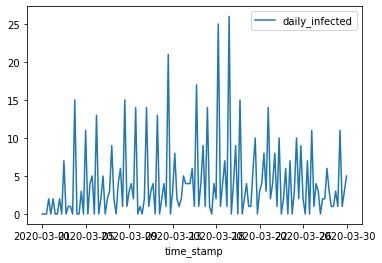

In [26]:
summary.plot(y="daily_infected")

If we want to get the full details, we can read the record:

In [27]:
read = RecordReader("./results")

In [28]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-03-01,North East,50.5,2,0.0,0,0,0,0,0
2020-03-02,North East,54.0,4,0.0,0,0,0,0,0
2020-03-03,North East,62.2,9,0.0,0,0,0,0,0


# Asking questions to the records

## Useful infections and death tables

In [29]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2021-09-21 13:40:41,579 - june.records.records_reader - INFO - Loading infections table
2021-09-21 13:40:41,588 - june.records.records_reader - INFO - Loading population table
2021-09-21 13:40:41,627 - june.records.records_reader - INFO - Merging infection and population tables
2021-09-21 13:40:41,630 - june.records.records_reader - INFO - Loading geography table
2021-09-21 13:40:41,651 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [30]:
infections_df.head(10)

,timestamp,location_ids,infector_ids,infection_ids,location_specs,region_names,age,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
9236,2020-03-01,4128,9217,170852960,household,North East,64,1799,4128,30,m,A1,company,household,0,E00042830,0,E02001731,North East
9186,2020-03-01,4256,9177,170852960,household,North East,48,1583,4256,30,m,A1,company,household,0,E00042830,0,E02001731,North East
9187,2020-03-02,4256,9177,170852960,household,North East,48,1390,4256,30,m,A1,company,household,0,E00042830,0,E02001731,North East
9110,2020-03-07,1456,9177,170852960,pub,North East,30,61,4228,30,m,A4,company,household,0,E00042830,0,E02001731,North East
9167,2020-03-08,4256,9186,170852960,household,North East,46,878,4256,30,m,A1,company,household,0,E00042830,0,E02001731,North East
9184,2020-03-11,4256,9186,170852960,household,North East,48,831,4256,30,m,A1,company,household,0,E00042830,0,E02001731,North East
9090,2020-03-30,1744,12276,170852960,company,North East,25,1744,4169,30,f,A1,company,household,0,E00042830,0,E02001731,North East
18525,2020-03-02,0,18891,170852960,university,North East,22,0,8803,63,m,A4,university,household,0,E00175575,0,E02001731,North East
18548,2020-03-06,0,16447,170852960,university,North East,24,0,8795,63,f,C4,university,household,0,E00175575,0,E02001731,North East
18562,2020-03-16,542,6075,170852960,company,North East,25,542,8730,63,m,A1,company,household,0,E00175575,0,E02001731,North East


In [31]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2021-09-21 13:40:41,682 - june.records.records_reader - INFO - Loading deaths table
2021-09-21 13:40:41,688 - june.records.records_reader - INFO - Loading population table
2021-09-21 13:40:41,729 - june.records.records_reader - INFO - Merging infection and population tables
2021-09-21 13:40:41,732 - june.records.records_reader - INFO - Loading geography table
2021-09-21 13:40:41,755 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [32]:
deaths_df.head(10)

,timestamp,location_ids,location_specs,age,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
id,,,,,,,,,,,,,,,,


## Sero-prevalence by age

In [33]:
age_bins = (0,20,60,100)

In [34]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [35]:
people_df = read.table_to_df('population')

In [36]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

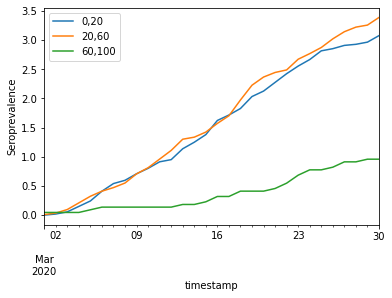

In [37]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("Seroprevalence")
plt.legend()

## Care home deaths in hospital

In [38]:
care_home_deaths_hospital = deaths_df[
    (deaths_df['location_specs'] == 'hospital') 
    & (deaths_df['residence_type'] == 'care_home')
]
care_home_deaths_hospital=care_home_deaths_hospital.groupby(
    ['name_region', 'timestamp']
).size()

In [39]:
try:
    care_home_deaths_hospital.unstack(level=0).plot()
except TypeError:
    print("this may fail if your simulation doesn't have care home deaths")

this may fail if your simulation doesn't have care home deaths


## Where people get infected as a function of time

In [40]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

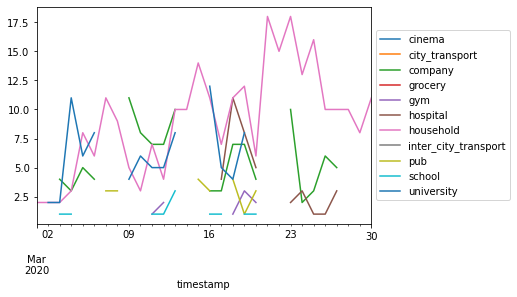

In [41]:
ax = locations_df.unstack(level=0).plot()
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))

Text(0.5, 0, 'location')

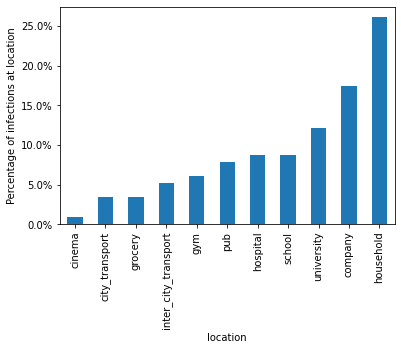

In [42]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')


## Where people of certain age get infected as a function of time

In [43]:
old_locations_df = infections_df[
    infections_df.age > 65
].groupby(['location_specs', 'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

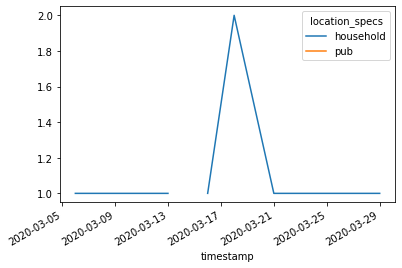

In [44]:
old_locations_df.unstack(level=0).plot()

## How many households have everyone infected?

In [45]:
n_infected_by_household = infections_df[
    infections_df['residence_type'] == 'household'
].groupby('residence_id').size()

In [46]:
residence_id = []
n_residents = []
for household in world.households:
    residence_id.append(household.id)
    n_residents.append(household.n_residents)
household_people = pd.DataFrame({"residence_id":residence_id, "n_residents":n_residents})

In [47]:
n_total_in_household = household_people[
    household_people['residence_id'].isin(
        n_infected_by_household.index
    )
]['n_residents']

Text(0.5, 0, '% of the household infected')

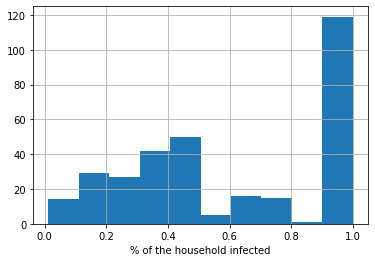

In [48]:
(n_infected_by_household/n_total_in_household).hist()
plt.xlabel('% of the household infected')

## Percentage of infected per care home

In [49]:
n_infected_by_carehome = infections_df[
    infections_df['residence_type'] == 'care_home'
].groupby(
    'residence_id'
).size()

In [50]:
n_total_in_carehome = people_df[
    (people_df['residence_type'] == 'care_home') 
    & (people_df['residence_id'].isin(n_infected_by_carehome.index))  
].groupby('residence_id').size()

Text(0.5, 0, '% of the care home infected')

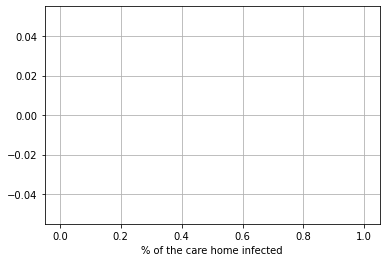

In [51]:
(n_infected_by_carehome/n_total_in_carehome).hist()
plt.xlabel('% of the care home infected')

In [52]:
# from all care homes, how many got at least one case?

In [53]:
n_total_care_homes = people_df[
    (people_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [54]:
n_total_care_homes

4

In [55]:
care_homes_with_infected = infections_df[
    (infections_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [56]:
care_homes_with_infected/n_total_care_homes

0.0